In [1]:
%matplotlib inline

import os
import datacube
import pandas
import matplotlib.pyplot as plt
import numpy as np
import sys
import rasterio
import xarray as xr
from odc.ui import with_ui_cbk

sys.path.append("Scripts")
from dea_plotting import display_map
from dea_datahandling import wofs_fuser
from dea_plotting import rgb

In [2]:
dc = datacube.Datacube(app="WOFS_Test")

In [3]:
# Define your area of interest
x = (147.34387, 147.60408)
y = (-35.12493, -35.49322)

# Define your period of interest
time = ("2017-1-01", "2017-12-31")

In [4]:
display_map(x=x,y=y)

In [5]:
# setting up a query with the given parameters, looking at the recent fire areas
query = {
    "x": x,
    "y": y,
    "time": time,
    "output_crs": "EPSG:3577",
    "resolution": (-25,25),
    "group_by": "solar_day",
    #"fuse_func": wofs_fuser,
}

In [6]:
# loading data from the datacube
wofls = dc.load(product="s1_gamma0_geotif_scene", **query)

In [7]:
print(wofls)

<xarray.Dataset>
Dimensions:  (time: 31, x: 1136, y: 1741)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01T19:24:01.446836 ... 2017-12-27T19:24:08.276281
  * y        (y) float64 -3.92e+06 -3.92e+06 -3.92e+06 ... -3.963e+06 -3.963e+06
  * x        (x) float64 1.387e+06 1.387e+06 1.387e+06 ... 1.415e+06 1.415e+06
Data variables:
    vh       (time, y, x) float32 0.012886789 0.015132018 ... 0.012017741
    vv       (time, y, x) float32 0.054096166 0.043761447 ... 0.08588637
Attributes:
    crs:      EPSG:3577


In [10]:
# creating a null object instead
zero_wofls = wofls.where(~wofls.isnull(), 0)
wofls["null_vh"] = zero_wofls.vh
wofls["null_vv"] = zero_wofls.vv

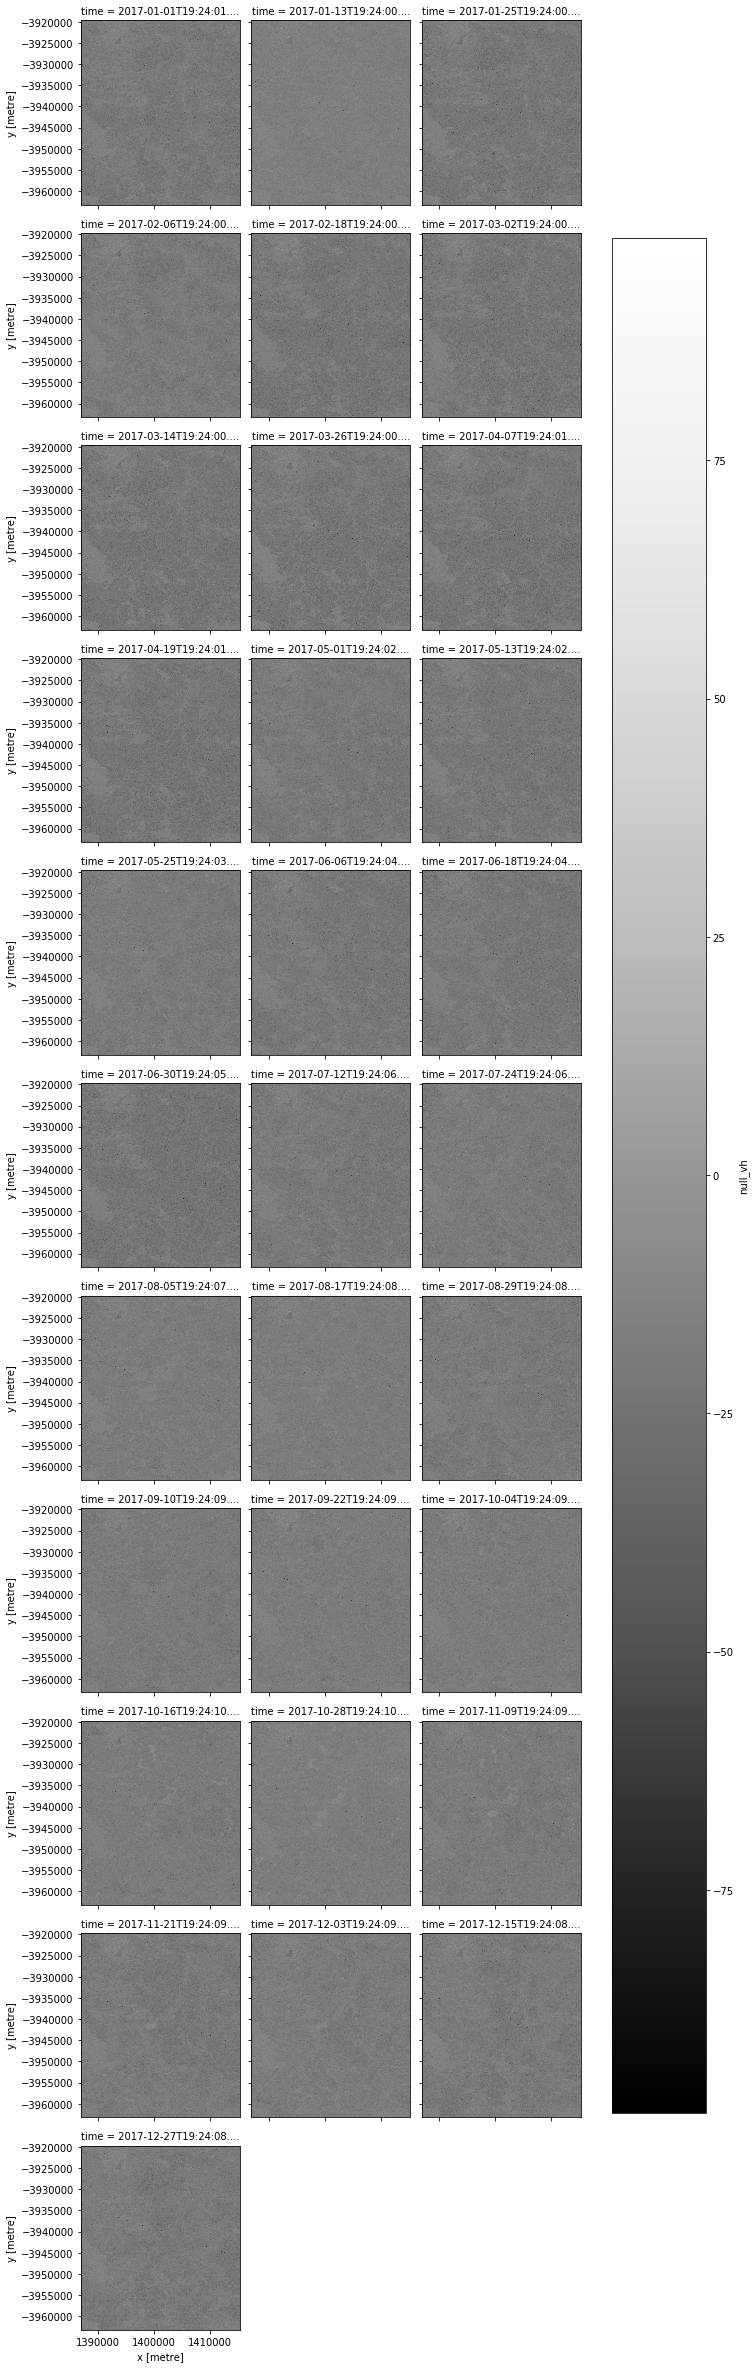

In [11]:
# generate a logarithmic plot of the vh data
wofls_vh = 10*np.log10(wofls.null_vh)
wofls_vh.plot(cmap="Greys_r", col = "time", col_wrap = 3)
plt.show()

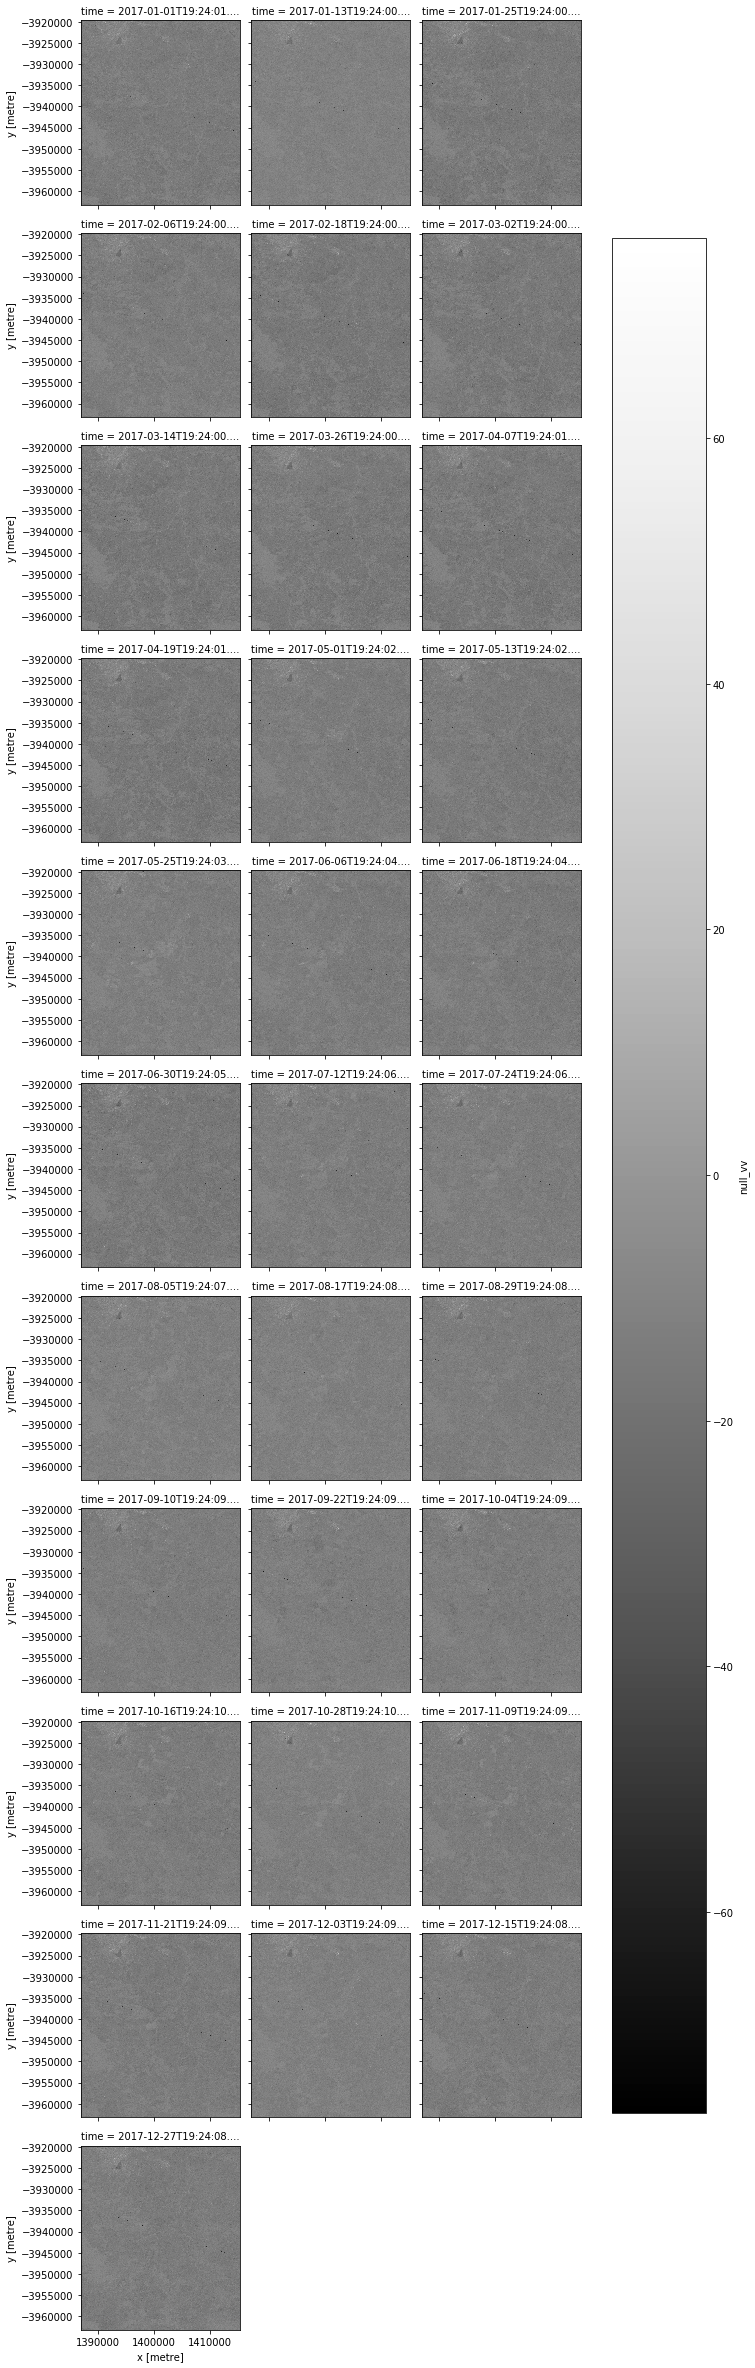

In [12]:
# generate a logarithmic plot of the vv data
wofls_vv = 10*np.log10(wofls.null_vv)
wofls_vv.plot(cmap="Greys_r", col = "time", col_wrap = 3)
plt.show()

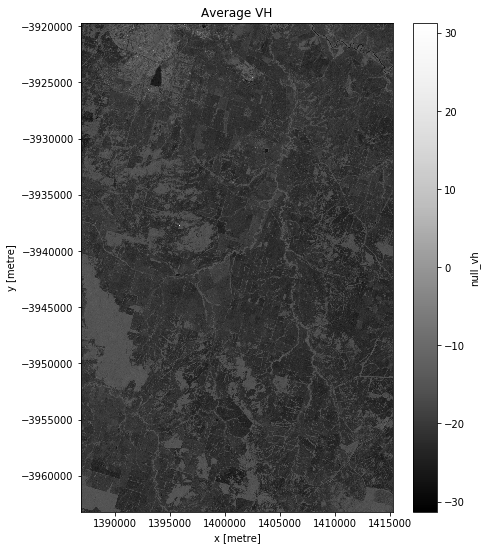

In [21]:
# creating averaged cmap plots

ave_wofls_vh = wofls_vh.mean(dim="time")
ave_wofls_vv = wofls_vv.mean(dim="time")
fig = plt.figure(figsize=(7,9))
ave_wofls_vh.plot(cmap="Greys_r")
plt.title("Average VH")
plt.show()

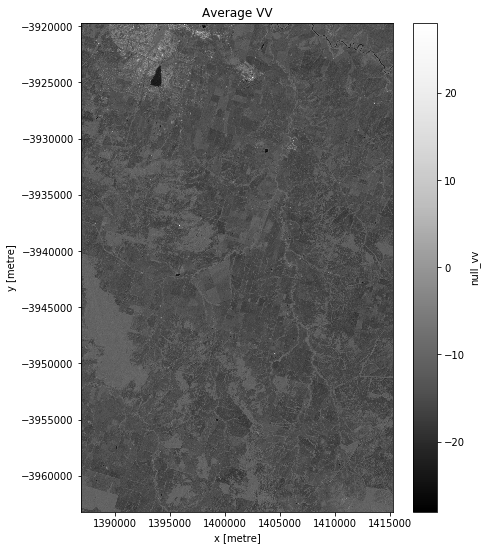

In [23]:
fig = plt.figure(figsize=(7,9))
ave_wofls_vv.plot(cmap="Greys_r")
plt.title("Average VV")
plt.show()

In [24]:
# this is a lee filter to reduce speckle effects, and I will add a Brevy filter later on for pan-sharpening if I can, although it may not be possible given the data type

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [25]:
# Set any null values to 0 before applying the filter to prevent issues
wofls_zero_filled = wofls.where(~wofls.isnull(), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
wofls["filtered_vv"] = wofls_zero_filled.vv.groupby('time').apply(lee_filter, size=7)
wofls["filtered_vh"] = wofls_zero_filled.vh.groupby('time').apply(lee_filter, size=7)

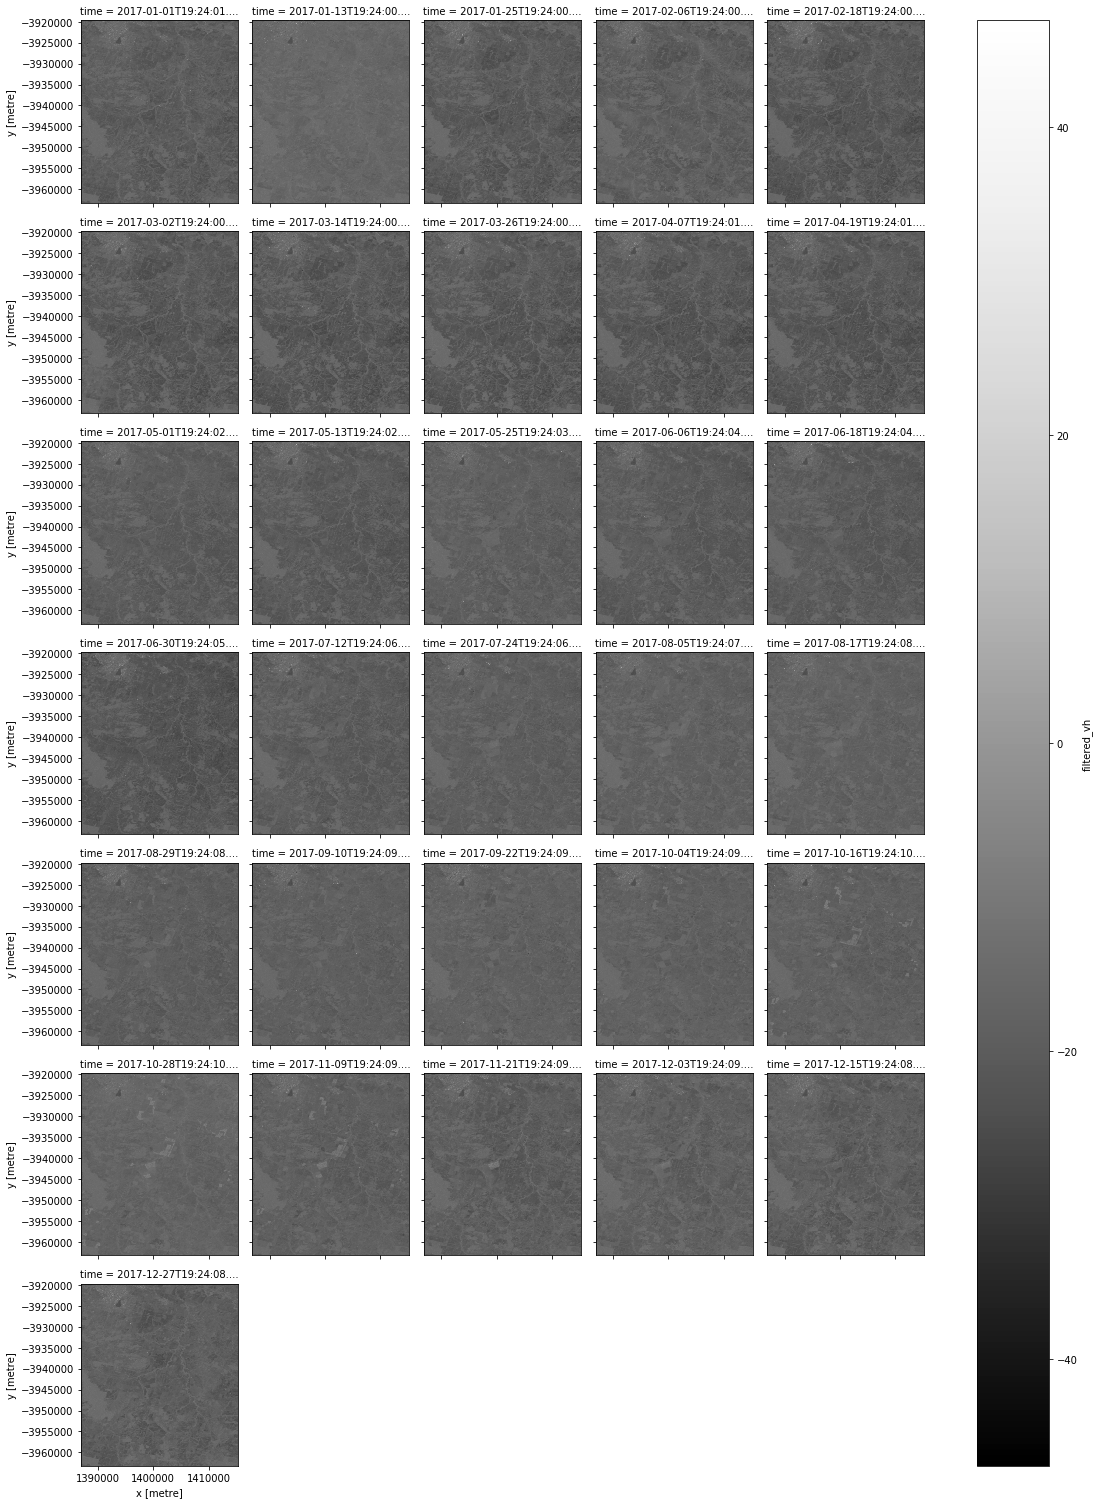

In [26]:
converted_filtered_vh = 10*np.log10(wofls.filtered_vh)  # Scale to plot data in decibels

converted_filtered_vh.plot(cmap="Greys_r", col="time", col_wrap=5)
plt.show()

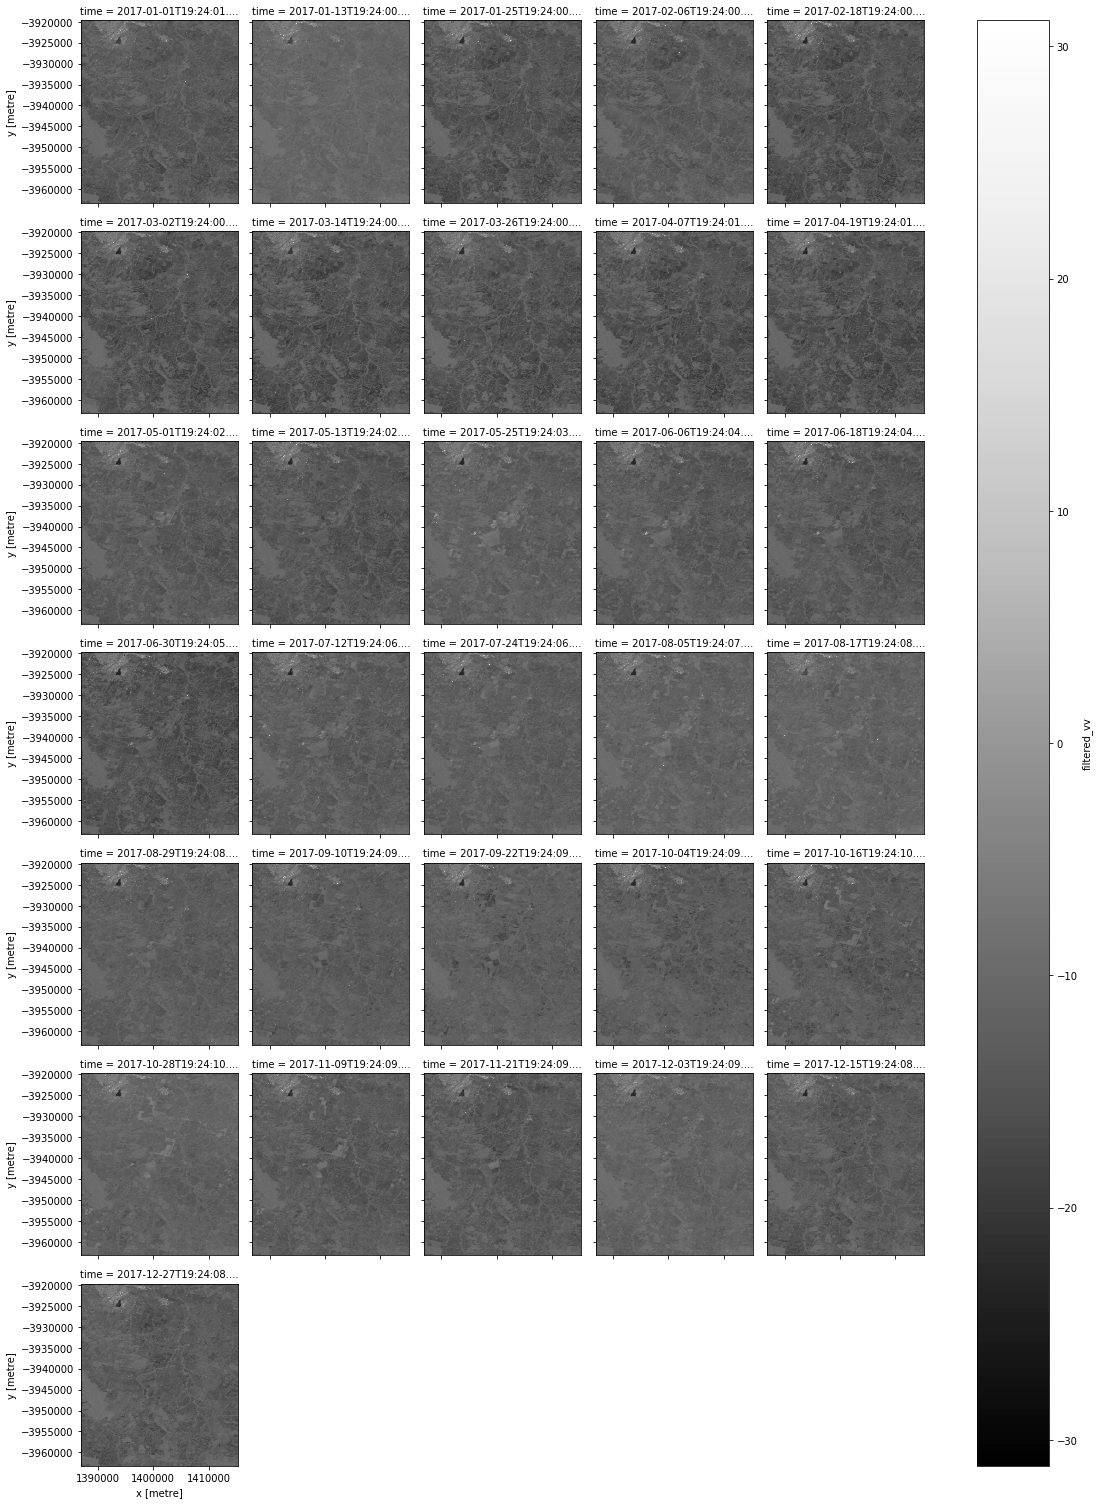

In [27]:
converted_filtered_vv = 10*np.log10(wofls.filtered_vv)  # Scale to plot data in decibels

converted_filtered_vv.plot(cmap="Greys_r", col="time", col_wrap=5)
plt.show()

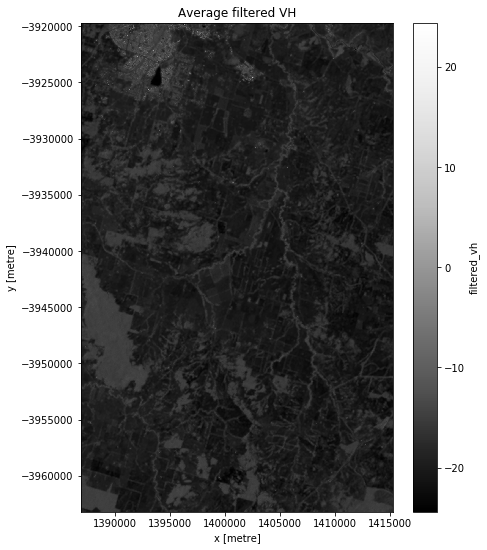

In [28]:
# Plot the average of all filtered VH observations

ave_converted_filtered_vh = converted_filtered_vh.mean(dim="time")

fig = plt.figure(figsize=(7,9))
ave_converted_filtered_vh.plot(cmap="Greys_r")
plt.title("Average filtered VH")
plt.show()

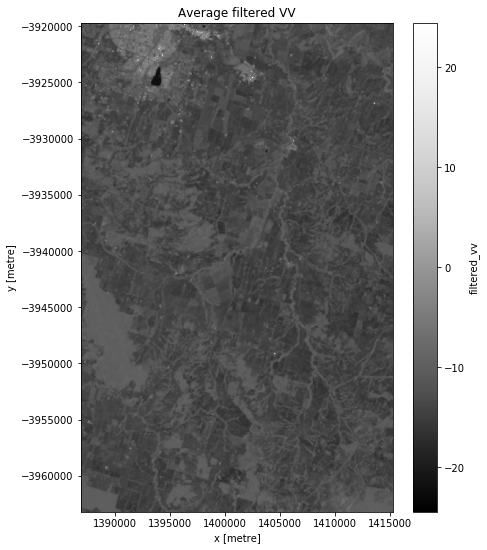

In [29]:
# Plot the average of all filtered VV observations

ave_converted_filtered_vv = converted_filtered_vv.mean(dim="time")

fig = plt.figure(figsize=(7,9))
ave_converted_filtered_vv.plot(cmap="Greys_r")
plt.title("Average filtered VV")
plt.show()

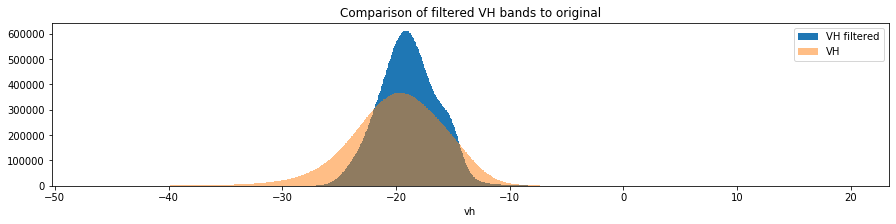

In [37]:
# creating histograms for the purpose of determining where water is most likely to be, based off of attenuation of SAR wavelengths

original_vh_db = 10*np.log10(wofls.vh)
filtered_vh_db = 10*np.log10(wofls.filtered_vh)

fig = plt.figure(figsize=(15,3))
filtered_vh_db.plot.hist(bins=1000, label="VH filtered")
original_vh_db.plot.hist(bins=1000, label="VH", alpha=.5,range=(-40,20))
plt.legend()
plt.title("Comparison of filtered VH bands to original")
plt.show()

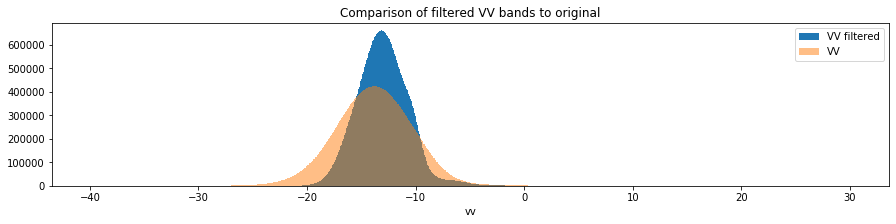

In [39]:
original_vv_db = 10*np.log10(wofls.vv)
filtered_vv_db = 10*np.log10(wofls.filtered_vv)

fig = plt.figure(figsize=(15,3))
filtered_vv_db.plot.hist(bins=1000, label="VV filtered")
original_vv_db.plot.hist(bins=1000, label="VV", alpha=.5,range=(-40,20))
plt.legend()
plt.title("Comparison of filtered VV bands to original")
plt.show()

In [41]:
# both cases appear to have peaks at the -13dB mark or thereabouts, with visual inspection of the lake in the required area indicating that water corresponds to -30dB
# hence, the threshold for water vs not water will be set at -30dB
threshold_vh=-30.0
# from here hopefully a corresponding section of histogram can be used with the validation data to create a semi-empirical relationship for determining soil moisture

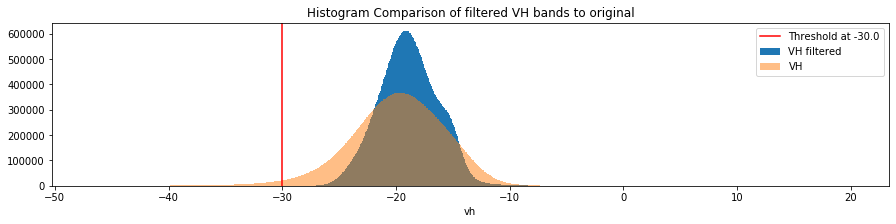

In [43]:
fig = plt.figure(figsize=(15,3))
plt.axvline(x=threshold_vh, label='Threshold at {}'.format(threshold), color="red")
filtered_vh_db.plot.hist(bins=1000, label="VH filtered")
original_vh_db.plot.hist(bins=1000, label="VH", alpha=.5,range=(-40,20))
plt.legend()
plt.title("Histogram Comparison of filtered VH bands to original") 
plt.show()

In [46]:
threshold_vv=-20.0
# this corresponds to the VV co-polarisation for water values

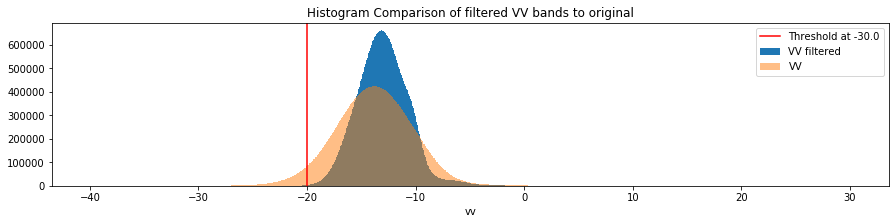

In [47]:
fig = plt.figure(figsize=(15,3))
plt.axvline(x=threshold_vv, label='Threshold at {}'.format(threshold), color="red")
filtered_vv_db.plot.hist(bins=1000, label="VV filtered")
original_vv_db.plot.hist(bins=1000, label="VV", alpha=.5,range=(-40,20))
plt.legend()
plt.title("Histogram Comparison of filtered VV bands to original") 
plt.show()

In [58]:
# a classifier can now be created to determine what is water and what isnt based off of either of the polarisations

def s1_water_classifier_vv(ds:xr.Dataset, threshold_vv=-20.0) -> xr.Dataset:
    assert "vv" in ds.data_vars, "This classifier is expecting a variable named `vv` expressed in DN, not DB values"
    filtered = ds.vv.groupby('time').apply(lee_filter, size=7)
    water_data_array = 10*np.log10(filtered) < threshold_vv
    return water_data_array.to_dataset(name="s1_water_vv")
def s1_water_classifier_vh(ds:xr.Dataset, threshold_vh=-25.0) -> xr.Dataset:
    assert "vh" in ds.data_vars, "This classifier is expecting a variable named `vh` expressed in DN, not DB values"
    filtered = ds.vh.groupby('time').apply(lee_filter, size=7)
    water_data_array = 10*np.log10(filtered) < threshold_vh
    return water_data_array.to_dataset(name="s1_water_vh")

In [59]:
# adding this to the wofls data cube
wofls["s1_water_vv"] = s1_water_classifier_vv(wofls).s1_water_vv
wofls["s1_water_vh"] = s1_water_classifier_vh(wofls).s1_water_vh

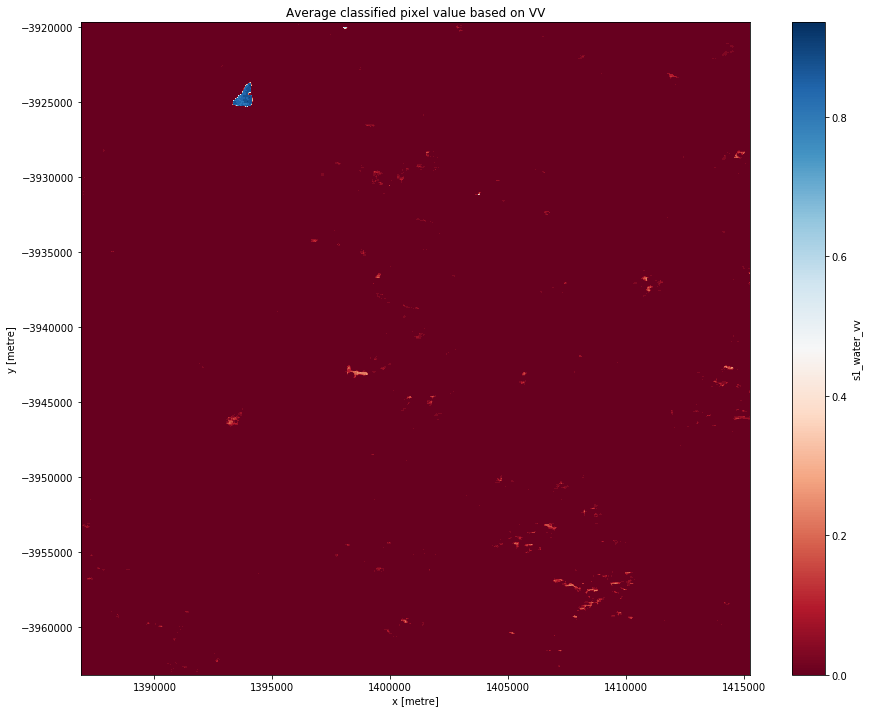

In [60]:
# this can now be plotted with the rest of the data

plt.figure(figsize=(15,12))
wofls.s1_water_vv.mean(dim="time").plot(cmap="RdBu")
plt.title("Average classified pixel value based on VV")
plt.show()

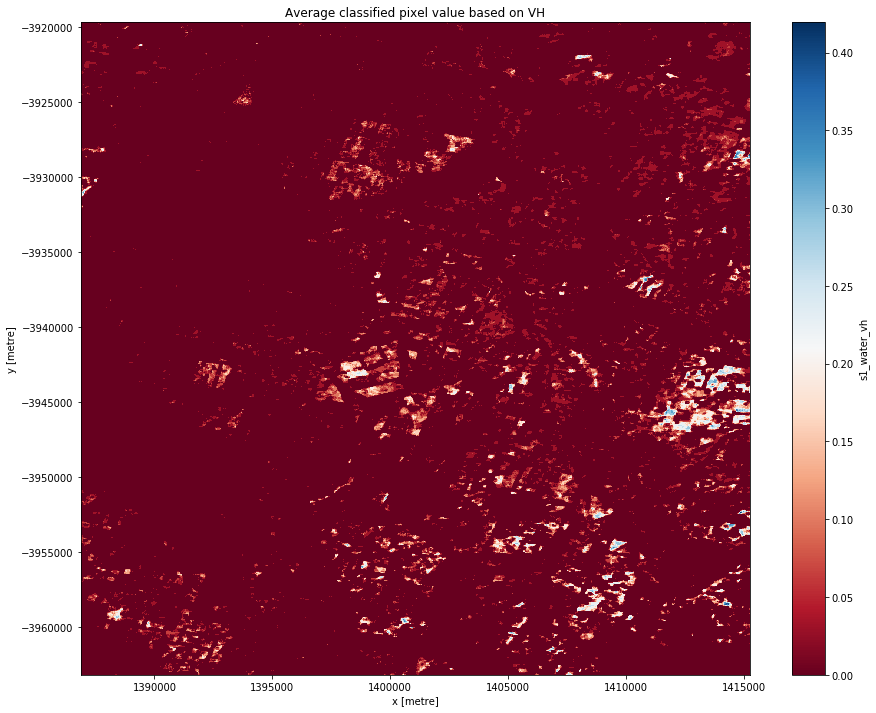

In [61]:
plt.figure(figsize=(15,12))
wofls.s1_water_vh.mean(dim="time").plot(cmap="RdBu")
plt.title("Average classified pixel value based on VH")
plt.show()